In [1]:
import numpy as np
import xarray as xr
import matplotlib as mpl
#mpl.use('Agg') # Must be before importing matplotlib.pyplot or pylab!
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import pandas as pd
import os
#import seaborn as sns
import timeit
#start_time = timeit.default_timer()
from datetime import datetime,timedelta
from dask.diagnostics import ProgressBar
from functools import partial
import dask

In [2]:
#setting progress bar visible
ProgressBar().register()
#making sure that xarray/dask splits large chunks while reading in data
dask.config.set({"array.slicing.split_large_chunks": True})

In [3]:
def _subset_process_time_hom(ds,var,iop):    
    #subset for the variable(s)
    ds = ds[var]
    ds['time'] = ds.time.dt.round('T')
    #IOP02
    if iop=='iop02': ds['time'] = pd.to_datetime('2019-08-22 22:00') + ds['time'].values
    #IOP03
    if iop=='iop03': ds['time'] = pd.to_datetime('2019-09-24') + ds['time'].values
    return(ds)

def _process_time_hom(ds,iop):
    #round time to the nearest minute (30minute for PALM output)
    ds['time'] = ds.time.dt.round('T')
    #IOP02
    if iop=='iop02':ds['time'] = pd.to_datetime('2019-08-22 22:00') + ds['time'].values
    #IOP03
    if iop=='iop03':ds['time'] = pd.to_datetime('2019-09-24') + ds['time'].values    
    return(ds)



In [4]:
#function to concatenate all files for an ensemble member and if needed read in all ensemble members
def open_concat_member_files_hom(ensemble_numbers,file,iop):
    data_list = []
    #loop through ensemble members
    if np.size(ensemble_numbers) > 1:
        for member_num in ensemble_numbers:    

            start_time = timeit.default_timer()
            if iop=='iop02': source_folder = '/bog/incoming/cheesehead/palm/realistic_runs/ches_IOP2_parent_child1_hom/ensemble.member.'+str(member_num) 
            #file = 'DATA_3D_AV_NETCDF_N02slice' 

            #Make a folder list and read in all the files from those folders. 
            folder_list = os.listdir(source_folder) 
            folder_list.sort() 
            file_list = [] 
            for folder in folder_list: 
                file_list.append(source_folder + '/' +folder+'/'+file) 
            file_list.sort()
            print(folder_list)

            #combine all the data along the time dimenstion 
            #don't combine them sequentially, but infer the sequence from coordinate values 
            #do this in parallel 
            #pull in only those values with a time dimension 
            var = ['w','theta','q','wtheta','wq']
            partial_func = partial(_subset_process_time_hom, var=var,iop=iop)
            # open_mfdataset() called without chunks argument will return dask arrays with chunk sizes 
            # equal to the individual files. Re-chunking the dataset after creation with ds.chunk() will 
            # lead to an ineffective use of memory and is not recommended
            ds = xr.open_mfdataset(file_list,preprocess=partial_func,chunks={'time': 8}) 
            ds.close()
            #check if the time index has only unique values 
            u, c = np.unique(ds.time.values, return_counts=True)
            #if not, keep the second, latest value for the ds
            if np.sum(c > 1) > 0 : ds = ds.drop_duplicates(dim='time', keep='last')

            print('Member',str(member_num),'finished collecting data')
            
            #subset for time and day and collect into another list
            #for day1
            data_list.append(ds)
            elapsed = timeit.default_timer() - start_time
            print('Done with member',str(member_num),' Time elapsed ',elapsed, 'seconds')
        return(data_list)
            
    else:
        member_num =ensemble_numbers

        #loop through ensemble members
        start_time = timeit.default_timer()
        #IOP02
        if iop=='iop02': source_folder = '/bog/incoming/cheesehead/palm/realistic_runs/ches_IOP2_parent_child1_hom/ensemble.member.'+str(member_num) 
        #IOP03
        if iop=='iop03':source_folder = '/bog/incoming/cheesehead/palm/realistic_runs/ches_IOP03/OUTPUT/ensemble.member.'+str(member_num) 
        
        #file = 'DATA_3D_AV_NETCDF_N03slice' 
        #file = 'DATA_1D_PR_NETCDF_N02slice' 

        #Make a folder list and read in all the files from those folders. 
        folder_list = os.listdir(source_folder) 
        folder_list.sort() 
        file_list = [] 
        for folder in folder_list: 
            file_list.append(source_folder + '/' +folder+'/'+file) 
        file_list.sort()
        print(folder_list)
        
        #combine all the data along the time dimenstion 
        partial_func = partial(_process_time_hom,iop=iop)    
        ds = xr.open_mfdataset(file_list,preprocess=partial_func) 
        ds.close() 
        print('Member',str(member_num),'finished collecting data')    
        #subset for time and day and collect into another list
        #for day1
        #data_list.append(ds)
        elapsed = timeit.default_timer() - start_time
        print('Done with member',str(member_num),' Time elapsed ',elapsed, 'seconds')
        return(ds)

In [5]:
def _subset_process_time(ds,var,iop):
    
    #subset for the variable(s)
    ds = ds[var]
    ds['time'] = ds.time.dt.round('T')
    #IOP02
    if iop=='iop02': ds['time'] = pd.to_datetime('2019-08-22') + ds['time'].values
    #IOP03
    if iop=='iop03': ds['time'] = pd.to_datetime('2019-09-24') + ds['time'].values
    return(ds)

def _process_time(ds,iop):
    #round time to the nearest minute (30minute for PALM output)
    ds['time'] = ds.time.dt.round('T')
    #IOP02
    if iop=='iop02':ds['time'] = pd.to_datetime('2019-08-22') + ds['time'].values
    #IOP03
    if iop=='iop03':ds['time'] = pd.to_datetime('2019-09-24') + ds['time'].values    
    return(ds)

#function to concatenate all files for an ensemble member and if needed read in all ensemble members
def open_concat_member_files(ensemble_numbers,file,iop):
    data_list = []
    #loop through ensemble members
    if np.size(ensemble_numbers) > 1:
        for member_num in ensemble_numbers:    

            start_time = timeit.default_timer()
            if iop=='iop02': source_folder = '/bog/incoming/cheesehead/palm/realistic_runs/ches_IOP2/ensemble.member.'+str(member_num) 
            if iop=='iop03': source_folder = '/bog/incoming/cheesehead/palm/realistic_runs/ches_IOP03/OUTPUT/ensemble.member.'+str(member_num) 
            #file = 'DATA_3D_AV_NETCDF_N02slice' 

            #Make a folder list and read in all the files from those folders. 
            folder_list = os.listdir(source_folder) 
            folder_list.sort() 
            file_list = [] 
            for folder in folder_list: 
                file_list.append(source_folder + '/' +folder+'/'+file) 
            file_list.sort()
            print(folder_list)

            #combine all the data along the time dimenstion 
            #don't combine them sequentially, but infer the sequence from coordinate values 
            #do this in parallel 
            #pull in only those values with a time dimension 
            var = ['w','theta','q','wtheta','wq']
            partial_func = partial(_subset_process_time, var=var,iop=iop)
            ds = xr.open_mfdataset(file_list,preprocess=partial_func) 
            ds.close() 
            print('Member',str(member_num),'finished collecting data')    
            #subset for time and day and collect into another list
            #for day1
            data_list.append(ds)
            elapsed = timeit.default_timer() - start_time
            print('Done with member',str(member_num),' Time elapsed ',elapsed, 'seconds')
        return(data_list)
            
    else:
        member_num =ensemble_numbers

        #loop through ensemble members
        start_time = timeit.default_timer()
        #IOP02
        if iop=='iop02':source_folder = '/bog/incoming/cheesehead/palm/realistic_runs/ches_IOP2/ensemble.member.'+str(member_num) 
        #IOP03
        if iop=='iop03':source_folder = '/bog/incoming/cheesehead/palm/realistic_runs/ches_IOP03/OUTPUT/ensemble.member.'+str(member_num) 
        
        #file = 'DATA_3D_AV_NETCDF_N03slice' 
        #file = 'DATA_1D_PR_NETCDF_N02slice' 

        #Make a folder list and read in all the files from those folders. 
        folder_list = os.listdir(source_folder) 
        folder_list.sort() 
        file_list = [] 
        for folder in folder_list: 
            file_list.append(source_folder + '/' +folder+'/'+file) 
        file_list.sort()
        print(folder_list)
        
        #combine all the data along the time dimenstion 
        partial_func = partial(_process_time,iop=iop)    
        ds = xr.open_mfdataset(file_list,preprocess=partial_func) 
        ds.close() 
        print('Member',str(member_num),'finished collecting data')    
        #subset for time and day and collect into another list
        #for day1
        #data_list.append(ds)
        elapsed = timeit.default_timer() - start_time
        print('Done with member',str(member_num),' Time elapsed ',elapsed, 'seconds')
        return(ds)

def calculate_turb_flux(ds):
    #subset for the variable(s)
    ds['theta_interpolated'] = ds.theta.rename({'zu_3d': 'zw_3d'}).interp_like(ds.w)
    ds['q_interpolated'] = ds.q.rename({'zu_3d': 'zw_3d'}).interp_like(ds.w)

    ds['wtheta_turb'] = ds['wtheta'] - ds.w*ds.theta_interpolated
    ds['wq_turb'] = ds['wq'] - ds.w*ds.q_interpolated


    ds['wtheta_turb_energy'] = ds['wtheta_turb']*1.17*1005
    ds['wq_turb_energy'] = ds['wq_turb']*1.17*1000*2501

    return ds

Fig. xx. Plot the ABL height averaged spatial variance of ensemble mean w, as a function of ensemble members

#### IOP02, Aug 23

In [53]:
#calculate values for N02, subset the domain to a 10x10 km domain from the centre.


#### Calculate the ABL height and w* for daytime, 1100 - 1600 for this subset


In [5]:
ensemble_member_ds_2_N02_iop02_hom = open_concat_member_files_hom(2,'DATA_3D_AV_NETCDF_N02slice','iop02')


['01.ches_IOP2_parent_child1_hom.22675', '02.ches_IOP2_parent_child1_hom.4647']
Member 2 finished collecting data
Done with member 2  Time elapsed  0.11425445973873138 seconds


In [6]:
#subset for the morning times
ensemble_member_ds_2_N02_iop02_hom = ensemble_member_ds_2_N02_iop02_hom.sel(time=slice('2019-08-23T11:00:00.000000000','2019-08-23T16:00:00.000000000'))

[########################################] | 100% Completed | 2.73 sms
[########################################] | 100% Completed | 1.11 sms
[########################################] | 100% Completed | 806.81 ms
[########################################] | 100% Completed | 807.06 ms
[########################################] | 100% Completed | 806.95 ms
[########################################] | 100% Completed | 1.01 sms
[########################################] | 100% Completed | 807.29 ms
[########################################] | 100% Completed | 1.01 sms
[########################################] | 100% Completed | 806.77 ms
[########################################] | 100% Completed | 806.97 ms
[########################################] | 100% Completed | 807.40 ms


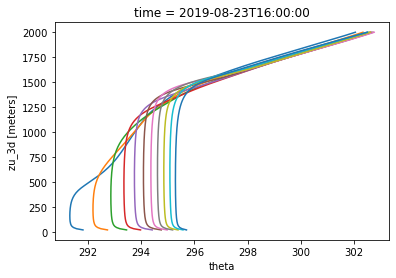

In [7]:
#have a look at the domain mean vertical profile of theta
IOP02_time_array = ensemble_member_ds_2_N02_iop02_hom.time.values

for i, time_step in enumerate(IOP02_time_array):
    ensemble_member_ds_2_N02_iop02_hom.sel(time = time_step,zu_3d=slice(10,2000)).mean('x').mean('y').theta.plot(y='zu_3d', label = str(time_step))


To calculate the ABL height I can subset the 3D data vertically, to couple of hundred metres  above the max theta change. This would reduce computation time and errors.



In [8]:
print(IOP02_time_array)
print('cut off heights' + ' 600, 800, 1100, 1300, 1500, 1600, 1600, 1700, 1700, 1700, 1700')

['2019-08-23T11:00:00.000000000' '2019-08-23T11:30:00.000000000'
 '2019-08-23T12:00:00.000000000' '2019-08-23T12:30:00.000000000'
 '2019-08-23T13:00:00.000000000' '2019-08-23T13:30:00.000000000'
 '2019-08-23T14:00:00.000000000' '2019-08-23T14:30:00.000000000'
 '2019-08-23T15:00:00.000000000' '2019-08-23T15:30:00.000000000'
 '2019-08-23T16:00:00.000000000']
cut off heights 600, 800, 1100, 1300, 1500, 1600, 1600, 1700, 1700, 1700, 1700


In [23]:
vertical_slice = [600, 800, 1100, 1300, 1500, 1600, 1600, 1700, 1700, 1700, 1800]

In [10]:
zi_theta_av_list = []

for i, time_step in enumerate(IOP02_time_array):
    zi_xy_av = (ensemble_member_ds_2_N02_iop02_hom.sel(time = time_step,zu_3d=slice(10,vertical_slice[i])).mean('x').mean('y').theta.differentiate(coord = 'zu_3d', edge_order=1, datetime_unit=None).idxmax(dim='zu_3d')).compute()
    zi_theta_av_list.append(zi_xy_av)


[########################################] | 100% Completed | 303.31 ms
[########################################] | 100% Completed | 303.17 ms
[########################################] | 100% Completed | 505.15 ms
[########################################] | 100% Completed | 505.08 ms
[########################################] | 100% Completed | 607.28 ms
[########################################] | 100% Completed | 606.09 ms
[########################################] | 100% Completed | 605.65 ms
[########################################] | 100% Completed | 706.80 ms
[########################################] | 100% Completed | 707.17 ms
[########################################] | 100% Completed | 706.38 ms
[########################################] | 100% Completed | 706.68 ms


In [11]:

time_stamp =  (ensemble_member_ds_2_N02_iop02_hom.time.dt.strftime('%H:%M'))


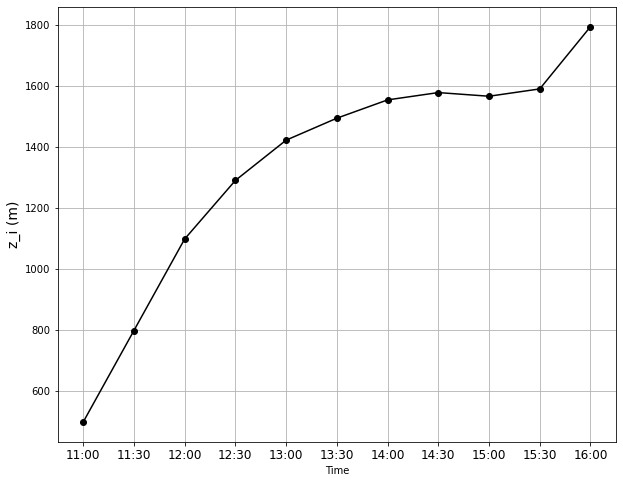

In [12]:
fig, (ax1) = plt.subplots(1,1,figsize=(10,8))

ax1.plot(time_stamp,np.asarray(xr.concat(zi_theta_av_list,'time')),'-o',color='black')
ax1.grid(True)
ax1.set_ylabel('z_i (m)',fontsize=14)
ax1.set_xlabel('Time')
ax1.grid(True)
tick_spacing = 1
ax1.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax1.tick_params(axis="x", labelsize=12)
#plt.axvline(x='13:00')

Neglect the kink at 16:00. Use other values

Calculate the w* values for the same time steps..



$w^{*}$ = $\left[ \frac{g}{\overline{\theta_{v}}} z_{i}  \overline{w'\theta_{v}'}   \right]^{1/3}$ 

$\overline{\theta_{v}} = \overline{\theta}(1 + 0.61\overline{q})$ 

$\overline{w'\theta_{v}'} = \overline{w'\theta'} + 0.61\overline{\theta}(\overline{w'q'})$  , Wyngaard 2010, Eq. 10.11

In [13]:
#near surface theta_bar
theta_bar = ensemble_member_ds_2_N02_iop02_hom.sel(zu_3d=6).mean('x').mean('y').theta.compute()
#near surface q_bar
q_bar = ensemble_member_ds_2_N02_iop02_hom.sel(zu_3d=6).mean('x').mean('y').q.compute()

[########################################] | 100% Completed | 101.53 ms
[########################################] | 100% Completed | 101.06 ms


In [14]:
#near surface theta_v
theta_v_bar = theta_bar*(1 + 0.61*q_bar)  
theta_v_bar

<xarray.DataArray (time: 11)>
array([293.81833, 294.63687, 295.21146, 295.66504, 296.0883 , 296.39822,
       296.56274, 296.73648, 296.9248 , 297.08093, 297.16092],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2019-08-23T11:00:00 ... 2019-08-23T16:00:00
    zu_3d    float64 6.0

In [15]:
#pull in the near surface heat and moisture flux from the domain mean profile data
profile_N02_member_2_ds = open_concat_member_files_hom(2,'DATA_1D_PR_NETCDF_N02slice','iop02')

['01.ches_IOP2_parent_child1_hom.22675', '02.ches_IOP2_parent_child1_hom.4647']
Member 2 finished collecting data
Done with member 2  Time elapsed  0.2538564167916775 seconds


In [16]:
#resample to 30 minutes and subset for the day
profile_N02_member_2_ds =  profile_N02_member_2_ds.resample(time='30T').mean().sel(time=slice('2019-08-23T11:00:00.000000000','2019-08-23T16:00:00.000000000'))

[########################################] | 100% Completed | 101.43 ms
[########################################] | 100% Completed | 101.18 ms
[########################################] | 100% Completed | 101.25 ms
[########################################] | 100% Completed | 101.26 ms
[########################################] | 100% Completed | 101.14 ms
[########################################] | 100% Completed | 101.21 ms
[########################################] | 100% Completed | 101.11 ms
[########################################] | 100% Completed | 101.27 ms
[########################################] | 100% Completed | 101.16 ms
[########################################] | 100% Completed | 101.12 ms
[########################################] | 100% Completed | 101.15 ms


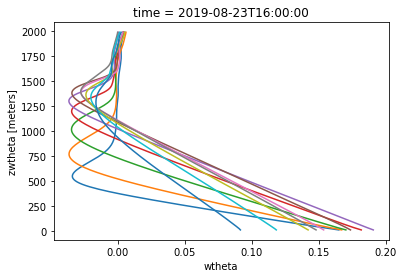

In [17]:
for i, time_step in enumerate(IOP02_time_array):
    profile_N02_member_2_ds.wtheta.sel(time = time_step,zwtheta=slice(10,2000)).plot(y='zwtheta')



In [18]:
wtheta_kinematic = profile_N02_member_2_ds.wtheta.sel(zwtheta=0)
wq_kinematic = profile_N02_member_2_ds.wq.sel(zwq=0)

wtheta_v = wtheta_kinematic + 0.61 * theta_bar * wq_kinematic


[########################################] | 100% Completed | 102.71 ms


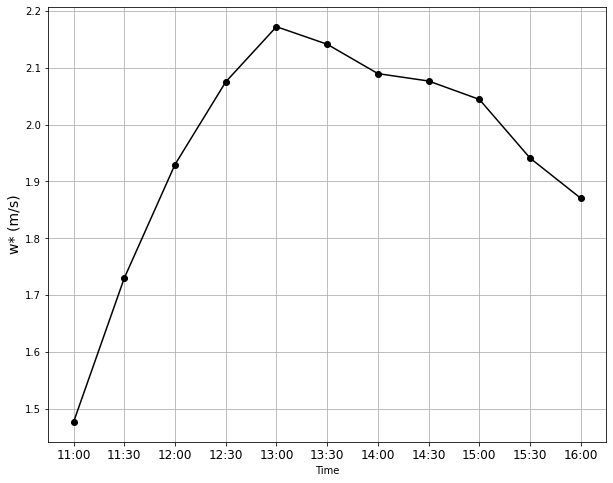

In [19]:
g = 9.8
zi_series = xr.concat(zi_theta_av_list,'time')
w_star_series = (g/theta_bar * zi_series * wtheta_v)**(1/3) 

fig, (ax1) = plt.subplots(1,1,figsize=(10,8))
ax1.plot(time_stamp,np.asarray(w_star_series),'-o',color='black')
ax1.grid(True)
ax1.set_ylabel('w* (m/s)',fontsize=14)
ax1.set_xlabel('Time')
ax1.grid(True)
tick_spacing = 1
ax1.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax1.tick_params(axis="x", labelsize=12)
#plt.axvline(x='13:00')

In [20]:
print(IOP02_time_array)
print(np.asarray(xr.concat(zi_theta_av_list,'time')))
print(np.asarray(w_star_series))


['2019-08-23T11:00:00.000000000' '2019-08-23T11:30:00.000000000'
 '2019-08-23T12:00:00.000000000' '2019-08-23T12:30:00.000000000'
 '2019-08-23T13:00:00.000000000' '2019-08-23T13:30:00.000000000'
 '2019-08-23T14:00:00.000000000' '2019-08-23T14:30:00.000000000'
 '2019-08-23T15:00:00.000000000' '2019-08-23T15:30:00.000000000'
 '2019-08-23T16:00:00.000000000']
[ 498.  798. 1098. 1290. 1422. 1494. 1554. 1578. 1566. 1590. 1794.]
[########################################] | 100% Completed | 102.60 ms
[1.47684437 1.73010462 1.92987103 2.07523696 2.17230979 2.14141793
 2.08973038 2.07670965 2.04437342 1.94107648 1.87042098]


#### Calculate the spatial variances as functions of ensemble member numbers, for 1100, 1200 and 1400


In [28]:
IOP02_time_array = ['2019-08-23T11:00:00.000000000', '2019-08-23T11:30:00.000000000',
 '2019-08-23T12:00:00.000000000', '2019-08-23T12:30:00.000000000',
 '2019-08-23T13:00:00.000000000', '2019-08-23T13:30:00.000000000',
 '2019-08-23T14:00:00.000000000', '2019-08-23T14:30:00.000000000',
 '2019-08-23T15:00:00.000000000', '2019-08-23T15:30:00.000000000',
 '2019-08-23T16:00:00.000000000']

# zi_theta_av_list_hom = [ 498.,  798., 1098., 1290., 1422., 1494., 1554., 1578., 1566., 1590., 1794.]

#for the 10x10 km subset
zi_theta_av_hom_list = [ 510.,  798., 1098., 1290., 1434., 1506., 1530., 1566., 1542.,
       1590., 1794.]

w_star_list_hom = [1.4768, 1.7301, 1.9298, 2.0752, 2.1723, 2.141,
 2.0897, 2.0767, 2.0443, 1.9410, 1.8704]

array([ 510.,  798., 1098., 1290., 1434., 1506., 1530., 1566., 1542.,
       1590., 1794.])

In [14]:
#create a dataset with all the ensembles.
member_list = np.arange(1,9)

ensemble_ds_iop02_N02_list = open_concat_member_files_hom(member_list,'DATA_3D_AV_NETCDF_N02slice','iop02')
ensemble_ds_iop02_N02_hom = xr.concat(ensemble_ds_iop02_N02_list,dim='ensemble')


['01.ches_IOP2_parent_child1_hom1.29566', '02. ches_IOP2_parent_child1_hom1.9162']
Member 1 finished collecting data
Done with member 1  Time elapsed  0.06898290477693081 seconds
['01.ches_IOP2_parent_child1_hom.22675', '02.ches_IOP2_parent_child1_hom.4647']
Member 2 finished collecting data
Done with member 2  Time elapsed  0.10249496437609196 seconds
['01.ches_IOP2_parent_child1_hom3.9492', '02.ches_IOP2_parent_child1_hom3.14926']
Member 3 finished collecting data
Done with member 3  Time elapsed  0.06408935226500034 seconds
['01.ches_IOP2_parent_child1_hom4.20276', '02.ches_IOP2_parent_child1_hom4.808']
Member 4 finished collecting data
Done with member 4  Time elapsed  0.06356121972203255 seconds
['0.ches_IOP2_parent_child1_hom5.19920', '01.ches_IOP2_parent_child1_hom5.26111', '02.ches_IOP2_parent_child1_hom5.21747']
Member 5 finished collecting data
Done with member 5  Time elapsed  0.09336601756513119 seconds
['01.ches_IOP2_parent_child1_hom6.20862', '02.ches_IOP2_parent_child1_h

In [12]:
#having a look at the dask chunk sizes
ensemble_ds_iop02_N02_hom.w

<xarray.DataArray 'w' (ensemble: 8, time: 39, zw_3d: 250, y: 1008, x: 900)>
dask.array<concatenate, shape=(8, 39, 250, 1008, 900), dtype=float32, chunksize=(1, 1, 250, 1008, 900), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2019-08-23T01:00:00 ... 2019-08-23T20:00:00
  * x        (x) float64 15.0 45.0 75.0 105.0 ... 2.692e+04 2.696e+04 2.698e+04
  * y        (y) float64 15.0 45.0 75.0 105.0 ... 3.016e+04 3.02e+04 3.022e+04
  * zw_3d    (zw_3d) float64 0.0 12.0 24.0 ... 2.964e+03 2.976e+03 2.988e+03
Dimensions without coordinates: ensemble
Attributes:
    units:      m/s
    long_name:  w

[########################################] | 100% Completed | 2.32 ss
[########################################] | 100% Completed | 16.21 ss


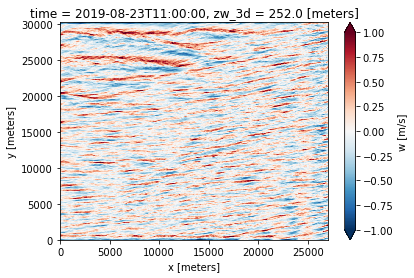

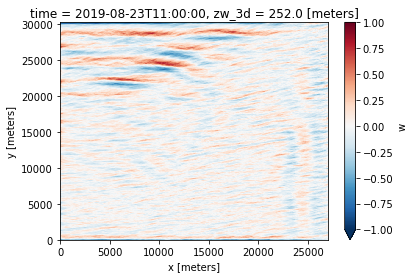

In [11]:
#have a look at the horizontal cross sections of w_av

ds_1 = ensemble_ds_iop02_N02_hom['w'].sel(ensemble=1,time='2019-08-23T11:00:00.000000000',zw_3d=252)
ds_1.plot(vmin=-1,vmax=1,cmap='RdBu_r')
plt.figure()
ds_2 = ensemble_ds_iop02_N02_hom['w'].sel(time='2019-08-23T11:00:00.000000000',zw_3d=252).mean('ensemble')
ds_2.plot(vmin=-1,vmax=1,cmap='RdBu_r')

In [15]:
#to remove the artefacts at the edges, consider a 10x10 km2 cross section centred around 
#the tall tower/model centre
#x has 900 values and y has 1008 values
#x midpoint is 449 and y midpoint is 503, in python index values
#from this midpoint, select a 10x10 km2 domain
#horizontal resolution = 30 m
#10000 m = 333 grid points
# which is 167 grid points on either directions to the centre.
#adding one grid point extra to the west and north to make the dimensions of spatila subset ~ 10 km
x_min = 449-167
x_max = 449+168

y_min = 503-167
y_max = 503+168

ds = ensemble_ds_iop02_N02_hom.isel(x=slice(x_min,x_max),y=slice(y_min,y_max))


[########################################] | 100% Completed | 14.81 ss


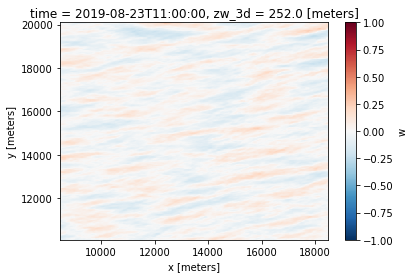

In [14]:
(ds['w'].sel(time='2019-08-23T11:00:00.000000000',zw_3d=252).mean('ensemble')/1.47).plot(vmin=-1,vmax=1,cmap='RdBu_r')
#ds['w'].sel(time='2019-08-23T11:00:00.000000000',zw_3d=252,ensemble=1).plot(vmin=-1,vmax=1,cmap='RdBu_r')

In [28]:
#looks better, check the horizontal extents of the data
print('Horizontal extent along x direction for the subset: ' + str((ds.w.x[-1] - ds.w.x[0]).values) + ' m')
print('Horizontal extent along y direction for the subset: ' + str((ds.w.y[-1] - ds.w.y[0]).values) + ' m')

Horizontal extent along x direction for the subset: 10020.0 m
Horizontal extent along y direction for the subset: 10020.0 m


In [24]:
#update zi for the smaller subset
zi_theta_av_hom_list = []
ensemble_member_ds_2_N02_iop02_hom = ds.sel(ensemble = 2)
for i, time_step in enumerate(IOP02_time_array):
    zi_xy_av = (ensemble_member_ds_2_N02_iop02_hom.sel(time = time_step,zu_3d=slice(10,vertical_slice[i])).mean('x').mean('y').theta.differentiate(coord = 'zu_3d', edge_order=1, datetime_unit=None).idxmax(dim='zu_3d')).compute()
    zi_theta_av_hom_list.append(zi_xy_av)
zi_theta_av_hom_list = xr.concat(zi_theta_av_hom_list,'time').values

[########################################] | 100% Completed | 5.34 sms
[########################################] | 100% Completed | 2.92 sms
[########################################] | 100% Completed | 2.72 sms
[########################################] | 100% Completed | 2.72 sms
[########################################] | 100% Completed | 2.72 sms
[########################################] | 100% Completed | 2.72 sms
[########################################] | 100% Completed | 2.72 sms
[########################################] | 100% Completed | 3.33 sms
[########################################] | 100% Completed | 2.02 sms
[########################################] | 100% Completed | 1.91 sms
[########################################] | 100% Completed | 1.91 sms


[########################################] | 100% Completed | 3.13 sms
[########################################] | 100% Completed | 3.23 s
[########################################] | 100% Completed | 3.33 s
[########################################] | 100% Completed | 3.13 sms
[########################################] | 100% Completed | 3.23 s
[########################################] | 100% Completed | 3.33 s
Member 1 done!
[########################################] | 100% Completed | 5.14 sms
[########################################] | 100% Completed | 5.24 s
[########################################] | 100% Completed | 5.34 s
[########################################] | 100% Completed | 5.14 sms
[########################################] | 100% Completed | 5.24 s
[########################################] | 100% Completed | 5.34 s
Member 2 done!
[########################################] | 100% Completed | 7.17 sms
[########################################] | 100% Completed | 7

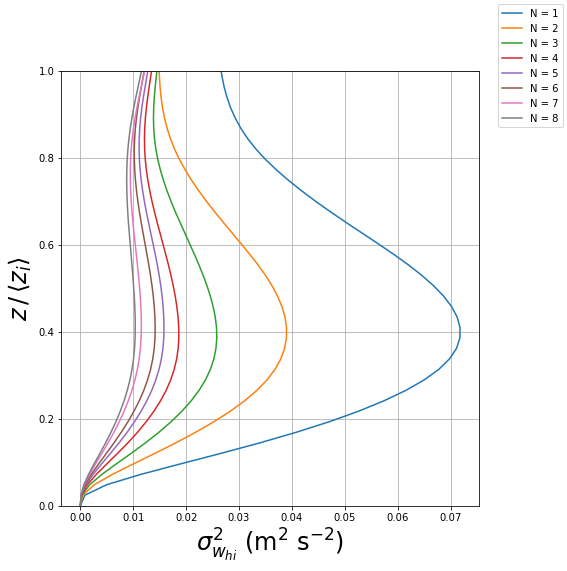

In [34]:
#have a look at the spatial variance profiles as a function of ensemble member numbers
zi = zi_theta_av_list[0]

fig = plt.figure(figsize=(8,8))
ax = fig.subplots(1,1)

for member_num in np.arange(1,9):
    #calculate variance
    
    #subset for the variable, var and time
    var_ds = ds['w'].sel(time=IOP02_time_array[0])
    
    #select the required number of ensembles
    var_hi = var_ds.sel(ensemble=slice(0,member_num)).mean('ensemble')
    #calculate spatial mean
    spatial_mean  = var_hi.mean('x').mean('y').compute()
    #calculate deviation from spatial mean and variance
    spatial_variance = (((var_hi - spatial_mean)**2).mean('x').mean('y').compute())
    y_axis = spatial_variance.zw_3d/zi
    ax.plot(np.asarray(spatial_variance),y_axis,'-',label= 'N = ' + str(member_num))
    print('Member ' + str(member_num) + ' done!')
ax.set_ylim([0,1])
fig.legend()
fig.subplots_adjust(right=0.85)
ax.set_xlabel(r'$\sigma^{2}_{w_{hi}}$ (m$^{2}$ s$^{-2}$)',fontsize=24)# w wind
ax.set_ylabel(r'$z\, /\, \langle z_{i} \rangle $',fontsize=24)
ax.grid(True)

In [31]:
#average the variance throughout the ABL height and calculate datapoints for each time
#write this as a function that takes inputs of ds, member_list, time_step and zi
# variance_list = []
# member_list = np.arange(1,9)

# #initialize time, zi 
# time_step = IOP02_time_array[0]
# zi = zi_theta_av_list[0]

def spatial_variance_abl_mean(ds,member_list,time_step,zi,var='w'):
    variance_list = []
    for member_num in member_list:
        #calculate variance

        #subset for the variable, var and time

        var_ds = ds[var].sel(time=time_step)

        #select the required number of ensembles
        var_hi = var_ds.sel(ensemble=slice(0,member_num)).mean('ensemble')
        #calculate spatial mean
        spatial_mean  = var_hi.mean('x').mean('y').compute()
        #calculate deviation from spatial mean and variance
        spatial_variance = (((var_hi - spatial_mean)**2).mean('x').mean('y').compute())
        #subset for ABL height, calculate mean
        variance_abl_mean = spatial_variance.sel(zw_3d=slice(0,zi)).mean()
        #add value to the variance list
        variance_list.append(variance_abl_mean)
        print('Member ' + str(member_num) + ' done!')
    return variance_list



Calculate and plot for 11, 12 and 14 in one graph. \
For hom. and het. runs..

In [12]:
#11
time_step = IOP02_time_array[0]
zi = zi_theta_av_hom_list[0]
variance_list_11_hom = spatial_variance_abl_mean(ds,np.arange(1,9),time_step,zi)

#12
time_step = IOP02_time_array[2]
zi = zi_theta_av_hom_list[2]
variance_list_12_hom = spatial_variance_abl_mean(ds,np.arange(1,9),time_step,zi)

#14
time_step = IOP02_time_array[6]
zi = zi_theta_av_hom_list[6]
variance_list_14_hom = spatial_variance_abl_mean(ds,np.arange(1,9),time_step,zi)


[########################################] | 100% Completed | 3.13 sms
[########################################] | 100% Completed | 3.12 sms
Member 1 done!
[########################################] | 100% Completed | 5.14 sms
[########################################] | 100% Completed | 5.14 sms
Member 2 done!
[########################################] | 100% Completed | 7.05 sms
[########################################] | 100% Completed | 7.16 sms
Member 3 done!
[########################################] | 100% Completed | 9.17 sms
[########################################] | 100% Completed | 9.18 sms
Member 4 done!
[########################################] | 100% Completed | 10.08 ss
[########################################] | 100% Completed | 10.09 ss
Member 5 done!
[########################################] | 100% Completed | 11.80 ss
[########################################] | 100% Completed | 11.99 ss
Member 6 done!
[########################################] | 100% Complete

[########################################] | 100% Completed | 3.12 sms
[########################################] | 100% Completed | 3.12 sms
Member 1 done!
[########################################] | 100% Completed | 5.14 sms
[########################################] | 100% Completed | 5.14 sms
Member 2 done!
[########################################] | 100% Completed | 7.16 sms
[########################################] | 100% Completed | 7.15 sms
Member 3 done!
[########################################] | 100% Completed | 9.08 sms
[########################################] | 100% Completed | 9.18 sms
Member 4 done!
[########################################] | 100% Completed | 13.53 ss
[########################################] | 100% Completed | 11.39 ss
Member 5 done!
[########################################] | 100% Completed | 12.90 ss
[########################################] | 100% Completed | 12.91 ss
Member 6 done!
[########################################] | 100% Complete

ABL mean spatial variance with increasing ensemble members for the homogeneous Aug 23 runs, 

In [19]:
print('At 11: ' + str(xr.concat(variance_list_11_hom, 'time').values))
print('At 12: ' + str(xr.concat(variance_list_12_hom, 'time').values))
print('At 14: ' + str(xr.concat(variance_list_14_hom, 'time').values))

At 11: [0.0446664  0.02414655 0.01702371 0.01306202 0.01138074 0.01023612
 0.00887156 0.00813641]
At 12: [0.13580133 0.05078574 0.03531709 0.02721469 0.02426958 0.02222756
 0.01772807 0.01461555]
At 14: [0.16797662 0.08466099 0.04980537 0.03629681 0.03335798 0.02742541
 0.03089103 0.02840591]


In [38]:
variance_list_11_hom = [0.0446664,  0.02414655, 0.01702371, 0.01306202, 0.01138074, 0.01023612,
 0.00887156, 0.00813641]
variance_list_12_hom = [0.13580133, 0.05078574, 0.03531709, 0.02721469, 0.02426958, 0.02222756,
 0.01772807, 0.01461555]
variance_list_14_hom = [0.16797662, 0.08466099, 0.04980537, 0.03629681, 0.03335798, 0.02742541,
 0.03089103, 0.02840591]


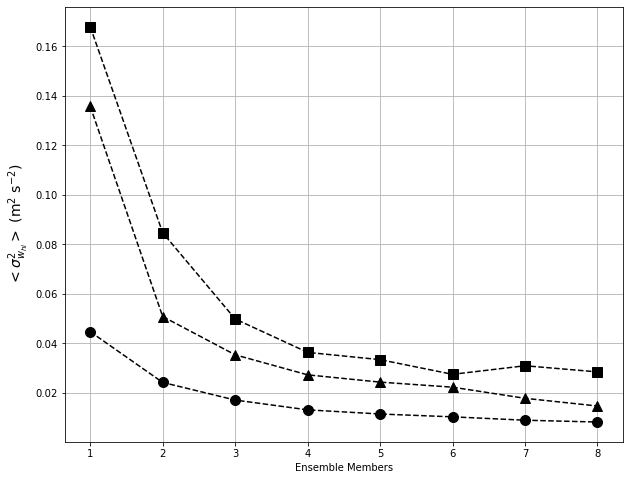

In [9]:
fig, ax1 = plt.subplots(1,1,figsize=(10,8))


# ax1.plot(member_list,xr.concat(variance_list_11_hom, 'time').values,'--o',color='black', markersize=10)
# ax1.plot(member_list,xr.concat(variance_list_12_hom, 'time').values,'--^',color='black', markersize=10)
# ax1.plot(member_list,xr.concat(variance_list_14_hom, 'time').values,'--s',color='black', markersize=10)
member_list = np.arange(1,9)
ax1.plot(member_list,variance_list_11_hom,'--o',color='black', markersize=10)
ax1.plot(member_list,variance_list_12_hom,'--^',color='black', markersize=10)
ax1.plot(member_list,variance_list_14_hom,'--s',color='black', markersize=10)

ax1.grid(True)
ax1.set_ylabel(r'$<\sigma^{2}_{w_{hi}}>$ (m$^{2}$ s$^{-2}$)',fontsize=14)
ax1.set_xlabel('Ensemble Members')
ax1.grid(True)
# tick_spacing = 1
# ax1.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
# ax1.tick_params(axis="x", labelsize=12)
#plt.axvline(x='13:00')

Now do the same for the het. run cases

In [12]:
#I have to redo the w* calculations for het. runs also
#did that!

In [10]:
#create a dataset with all the ensembles.
member_list = np.arange(1,9)

ensemble_ds_iop02_N02_list = open_concat_member_files(member_list,'DATA_3D_AV_NETCDF_N02slice','iop02')
ensemble_ds_iop02_N02 = xr.concat(ensemble_ds_iop02_N02_list,dim='ensemble')


['01.ches_IOP2.24050', '02.ches_IOP2.10023', '03.ches_IOP2.28390', '04.ches_IOP2.20941', '05.ches_IOP2.13864', '06.ches_IOP2.31028', '07.ches_IOP2.19931', '08.ches_IOP2.19743']
Member 1 finished collecting data
Done with member 1  Time elapsed  2.27466806396842 seconds
['01.ches_IOP2.20255', '02.ches_IOP2.13449', '03.ches_IOP2.733', '04.ches_IOP2.18198', '05.ches_IOP2.19794', '06.ches_IOP2.11638', '07.ches_IOP02.31113']
Member 2 finished collecting data
Done with member 2  Time elapsed  0.26804571598768234 seconds
['01.ches_IOP2.2199', '02.ches_IOP2.11581', '03.ches_IOP2.26923', '04.ches_IOP2.16339', '05.ches_IOP2.10214', '06.ches_IOP2.17190', '07.ches_IOP2.19176']
Member 3 finished collecting data
Done with member 3  Time elapsed  2.0860949866473675 seconds
['01.ches_IOP2.5461', '02.ches_IOP2.19281', '03.ches_IOP2.11295', '04.ches_IOP2.14610', '05.ches_IOP2.24393', '06. ches_IOP2.29130', '07. ches_IOP2.18966']
Member 4 finished collecting data
Done with member 4  Time elapsed  2.29900

In [16]:
#subset it for the 10x10 smaller domain 
ds_het = ensemble_ds_iop02_N02.isel(x=slice(x_min,x_max),y=slice(y_min,y_max))


In [18]:
zi_theta_av_list = []
ensemble_member_ds_2_N02_iop02 = ds_het.sel(ensemble=2)
vertical_slice =  [ 900,  1200, 1300 , 1400, 1700 ,
       1700 , 1700 , 1700   , 1700  , 1700 ,
        1200]    
for i, time_step in enumerate(IOP02_time_array):
    zi_xy_av = (ensemble_member_ds_2_N02_iop02.sel(time = time_step,zu_3d=slice(0,vertical_slice[i])).theta.differentiate(coord = 'zu_3d', edge_order=1, datetime_unit=None).idxmax(dim='zu_3d')).mean('x').mean('y').compute()
    zi_theta_av_list.append(zi_xy_av)
zi_theta_av_list = xr.concat(zi_theta_av_list,'time').values

[########################################] | 100% Completed | 14.40 s
[########################################] | 100% Completed | 11.08 s
[########################################] | 100% Completed | 10.78 s
[########################################] | 100% Completed | 10.78 s
[########################################] | 100% Completed | 10.88 s
[########################################] | 100% Completed | 10.78 s
[########################################] | 100% Completed | 10.78 s
[########################################] | 100% Completed | 10.78 s
[########################################] | 100% Completed | 10.78 s
[########################################] | 100% Completed | 10.67 s
[########################################] | 100% Completed | 11.98 s


In [29]:
w_star_list = [1.6306372,  1.87832223, 1.93912139, 2.09285816, 2.25351041, 2.23918977,
 2.08612784, 2.08723152, 2.1083716,  2.03151429, 1.51969396]

In [40]:
ds_het = ensemble_ds_iop02_N02

In [41]:
#11
time_step = IOP02_time_array[0]
zi = zi_theta_av_list[0]
variance_list_11 = spatial_variance_abl_mean(ds_het,np.arange(1,9),time_step,zi)

#12
time_step = IOP02_time_array[2]
zi = zi_theta_av_list[2]
variance_list_12 = spatial_variance_abl_mean(ds_het,np.arange(1,9),time_step,zi)

#14
time_step = IOP02_time_array[6]
zi = zi_theta_av_list[6]
variance_list_14 = spatial_variance_abl_mean(ds_het,np.arange(1,9),time_step,zi)


[########################################] | 100% Completed | 16.95 s
[########################################] | 100% Completed | 15.41 s
Member 1 done!
[########################################] | 100% Completed | 20.68 s
[########################################] | 100% Completed | 20.97 s
Member 2 done!
[########################################] | 100% Completed | 25.03 s
[########################################] | 100% Completed | 26.60 s
Member 3 done!
[########################################] | 100% Completed | 30.88 s
[########################################] | 100% Completed | 31.21 s
Member 4 done!
[########################################] | 100% Completed | 34.08 s
[########################################] | 100% Completed | 34.34 s
Member 5 done!
[########################################] | 100% Completed | 39.17 s
[########################################] | 100% Completed | 39.77 s
Member 6 done!
[########################################] | 100% Completed | 45.89 s


In [35]:
print('At 11: ' + str(xr.concat(variance_list_11, 'time').values))
print('At 12: ' + str(xr.concat(variance_list_12, 'time').values))
print('At 14: ' + str(xr.concat(variance_list_14, 'time').values))

At 11: [0.0931665  0.07706314 0.06277265 0.06174638 0.05930538 0.05916772
 0.05990629 0.05904618]
At 12: [0.1552744  0.08444825 0.05957185 0.05409292 0.04871551 0.04612057
 0.04365833 0.04028858]
At 14: [0.17332517 0.09489044 0.06286006 0.04397106 0.03622213 0.02829871
 0.0246389  0.02322019]


Values without subsetting:

In [42]:
print('At 11: ' + str(xr.concat(variance_list_11, 'time').values))
print('At 12: ' + str(xr.concat(variance_list_12, 'time').values))
print('At 14: ' + str(xr.concat(variance_list_14, 'time').values))

At 11: [0.08124074 0.06278578 0.05430002 0.0520623  0.05014247 0.04886467
 0.04891437 0.04853681]
At 12: [0.12634088 0.08427902 0.0652423  0.05930222 0.05624119 0.05310366
 0.04993189 0.0452429 ]
At 14: [0.18821467 0.11284998 0.08441609 0.07301995 0.06463932 0.05593271
 0.05303199 0.04863912]


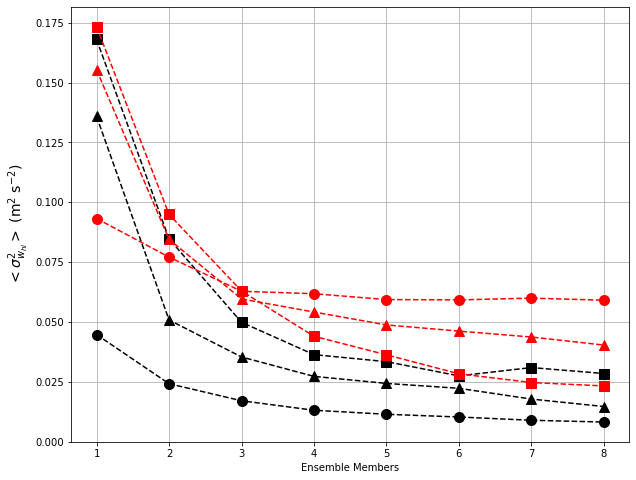

In [39]:
fig, ax1 = plt.subplots(1,1,figsize=(10,8))


# ax1.plot(member_list,xr.concat(variance_list_11_hom, 'time').values,'--o',color='black', markersize=10)
# ax1.plot(member_list,xr.concat(variance_list_12_hom, 'time').values,'--^',color='black', markersize=10)
# ax1.plot(member_list,xr.concat(variance_list_14_hom, 'time').values,'--s',color='black', markersize=10)
member_list = np.arange(1,9)

ax1.plot(member_list,variance_list_11_hom/(w_star_list_hom[0]**2),'--o',color='black', markersize=10)
ax1.plot(member_list,variance_list_12_hom/(w_star_list_hom[2]**2),'--^',color='black', markersize=10)
ax1.plot(member_list,variance_list_14_hom/(w_star_list_hom[6]**2),'--s',color='black', markersize=10)

ax1.plot(member_list,variance_list_11/(w_star_list[0]**2),'--o',color='red', markersize=10)
ax1.plot(member_list,variance_list_12/(w_star_list[2]**2),'--^',color='red', markersize=10)
ax1.plot(member_list,variance_list_14/(w_star_list[6]**2),'--s',color='red', markersize=10)

ax1.grid(True)
ax1.set_ylabel(r'$<\sigma^{2}_{w_{hi}}>$ (m$^{2}$ s$^{-2}$)',fontsize=14)
ax1.set_xlabel('Ensemble Members')
ax1.grid(True)
# tick_spacing = 1
# ax1.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
# ax1.tick_params(axis="x", labelsize=12)
#plt.axvline(x='13:00')

In [44]:
variance_list_11 =  [0.0931665,  0.07706314, 0.06277265, 0.06174638, 0.05930538, 0.05916772,
 0.05990629, 0.05904618]
variance_list_12 = [0.1552744,  0.08444825, 0.05957185, 0.05409292, 0.04871551, 0.04612057,
 0.04365833, 0.04028858]
variance_list_14 = [0.17332517, 0.09489044, 0.06286006, 0.04397106, 0.03622213, 0.02829871,
 0.0246389,  0.02322019]


array([0.03503847, 0.02898224, 0.02360781, 0.02322185, 0.02230383,
       0.02225206, 0.02252982, 0.02220635])

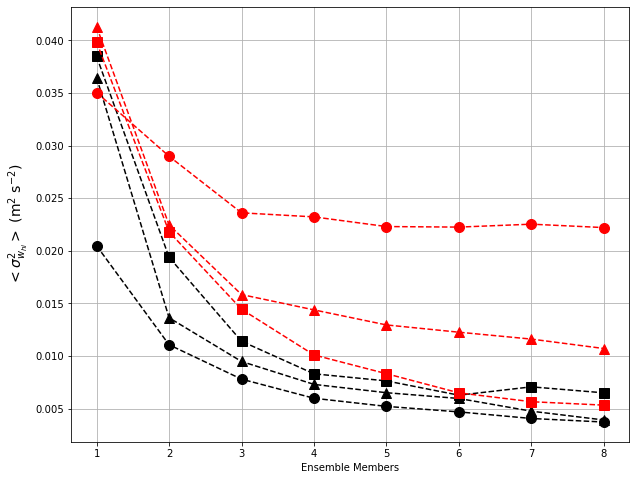

In [53]:
fig, ax1 = plt.subplots(1,1,figsize=(10,8))


# ax1.plot(member_list,xr.concat(variance_list_11_hom, 'time').values,'--o',color='black', markersize=10)
# ax1.plot(member_list,xr.concat(variance_list_12_hom, 'time').values,'--^',color='black', markersize=10)
# ax1.plot(member_list,xr.concat(variance_list_14_hom, 'time').values,'--s',color='black', markersize=10)
member_list = np.arange(1,9)

ax1.plot(member_list,np.array(variance_list_11_hom)/(w_star_list_hom[0]**2),'--o',color='black', markersize=10)
ax1.plot(member_list,np.array(variance_list_12_hom)/(w_star_list_hom[2]**2),'--^',color='black', markersize=10)
ax1.plot(member_list,np.array(variance_list_14_hom)/(w_star_list_hom[6]**2),'--s',color='black', markersize=10)

ax1.plot(member_list,np.array(variance_list_11)/(w_star_list[0]**2),'--o',color='red', markersize=10)
ax1.plot(member_list,np.array(variance_list_12)/(w_star_list[2]**2),'--^',color='red', markersize=10)
ax1.plot(member_list,np.array(variance_list_14)/(w_star_list[6]**2),'--s',color='red', markersize=10)

ax1.grid(True)
ax1.set_ylabel(r'$<\sigma^{2}_{w_{hi}}>$ (m$^{2}$ s$^{-2}$)',fontsize=14)
ax1.set_xlabel('Ensemble Members')
ax1.grid(True)
# tick_spacing = 1
# ax1.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
# ax1.tick_params(axis="x", labelsize=12)
#plt.axvline(x='13:00')

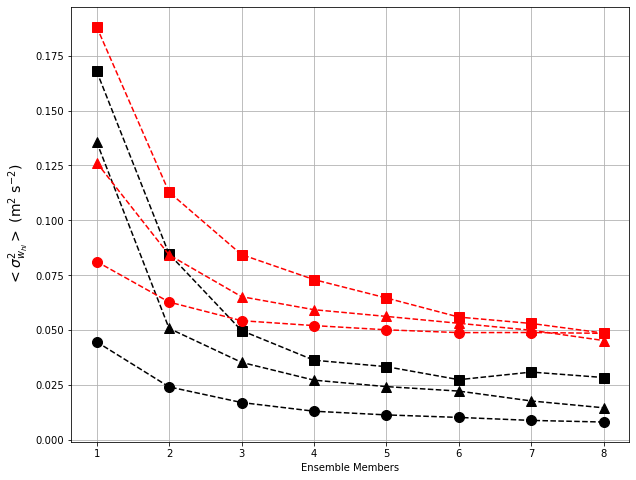

In [43]:
#plot without sub setting
fig, ax1 = plt.subplots(1,1,figsize=(10,8))


# ax1.plot(member_list,xr.concat(variance_list_11_hom, 'time').values,'--o',color='black', markersize=10)
# ax1.plot(member_list,xr.concat(variance_list_12_hom, 'time').values,'--^',color='black', markersize=10)
# ax1.plot(member_list,xr.concat(variance_list_14_hom, 'time').values,'--s',color='black', markersize=10)
member_list = np.arange(1,9)

ax1.plot(member_list,variance_list_11_hom,'--o',color='black', markersize=10)
ax1.plot(member_list,variance_list_12_hom,'--^',color='black', markersize=10)
ax1.plot(member_list,variance_list_14_hom,'--s',color='black', markersize=10)

ax1.plot(member_list,variance_list_11,'--o',color='red', markersize=10)
ax1.plot(member_list,variance_list_12,'--^',color='red', markersize=10)
ax1.plot(member_list,variance_list_14,'--s',color='red', markersize=10)

ax1.grid(True)
ax1.set_ylabel(r'$<\sigma^{2}_{w_{hi}}>$ (m$^{2}$ s$^{-2}$)',fontsize=14)
ax1.set_xlabel('Ensemble Members')
ax1.grid(True)
# tick_spacing = 1
# ax1.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
# ax1.tick_params(axis="x", labelsize=12)
#plt.axvline(x='13:00')

Let me see how this looks. If it is not different from the plot for subset, I will have only the hom. values in this plot. Then have a full profile plot for the het. runs

I need to normalize this by $w*^{2}$

Okay, normalizing by w* did not help out all that much. the 